In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [39]:
# Paths and image settings
base_dir = '/kaggle/input/rp-rice-leaf-dataset/Rice Leaf Diseases Dataset'
preprocessed_dir = '/kaggle/working/preprocessed_rice_leaf_dataset'
img_height, img_width = 227, 227
batch_size = 64

In [40]:
# Step 1: Preprocess Images and Save Them as Image Files

def preprocess_image(image):
    """Apply grayscale conversion and segmentation techniques."""
    # Convert to grayscale
    gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Apply Watershed Segmentation
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 0] = 0
    markers = cv2.watershed(image.astype(np.uint8), markers)
    image[markers == -1] = [255, 0, 0]

    # Apply Graph Cut Segmentation (GrabCut)
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img_width - 10, img_height - 10)
    cv2.grabCut(image.astype(np.uint8), mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    image = image * mask2[:, :, np.newaxis]
    
    return image


def preprocess_and_save_images():
    """Preprocess images from the dataset and save them as image files."""
    if not os.path.exists(preprocessed_dir):
        os.makedirs(preprocessed_dir)
    
    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        save_category_path = os.path.join(preprocessed_dir, category)
        
        if not os.path.exists(save_category_path):
            os.makedirs(save_category_path)

        for img_name in tqdm(os.listdir(category_path), desc=f'Processing {category}'):
            img_path = os.path.join(category_path, img_name)
            image = load_img(img_path, target_size=(img_height, img_width))
            image = img_to_array(image)
            preprocessed_image = preprocess_image(image)

            # Save preprocessed image as .png
            save_path = os.path.join(save_category_path, img_name.split('.')[0] + '.jpg')
            cv2.imwrite(save_path, preprocessed_image)

# Run preprocessing to save all preprocessed images as .jpg files
preprocess_and_save_images()

Processing Bacterial Leaf Blight: 100%|██████████| 4000/4000 [53:17<00:00,  1.25it/s]  


In [46]:
# Step 2: Load Preprocessed Images for Training

def custom_data_generator(preprocessed_dir, batch_size, img_height, img_width, class_indices):
    """Custom generator for loading preprocessed images."""
    categories = os.listdir(preprocessed_dir)
    
    while True:
        X_batch = []
        y_batch = []
        
        for _ in range(batch_size):
            category = np.random.choice(categories)
            category_path = os.path.join(preprocessed_dir, category)
            image_name = np.random.choice(os.listdir(category_path))
            
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_width, img_height))  # Resize if necessary
            image = image / 255.0  # Normalize image to [0, 1]
            
            X_batch.append(image)
            y_batch.append(class_indices[category])
        
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        y_batch = to_categorical(y_batch, num_classes=len(class_indices))
        
        yield X_batch, y_batch

# Initialize ImageDataGenerator to get class indices
train_generator = ImageDataGenerator().flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

class_indices = train_generator.class_indices

# Create generators for preprocessed data
train_generator_preprocessed = custom_data_generator(preprocessed_dir, batch_size, img_height, img_width, class_indices)

# Use original images for validation
val_datagen = ImageDataGenerator(validation_split=0.2)  # 20% for validation

# Create validation generator from original dataset
val_generator_original = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

train_samples = sum([len(os.listdir(os.path.join(preprocessed_dir, category))) for category in class_indices.keys()])
val_samples = val_generator_original.samples

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

# Ensure there's at least one step in both training and validation
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

Found 16000 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [47]:
# Step 3: Build and Train the Model

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)  # Dynamic num_classes

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [49]:
# Test validation generator
x_val_batch, y_val_batch = next(val_generator_original)
print(f'Validation batch shape: {x_val_batch.shape}, {y_val_batch.shape}')

Validation batch shape: (64, 227, 227, 3), (64, 4)


In [52]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator_original,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 226s 884ms/step - accuracy: 0.9399 - loss: 0.1753 - val_accuracy: 0.9741 - val_loss: 0.0766 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 813ms/step - accuracy: 0.9800 - loss: 0.0613 - val_accuracy: 0.9525 - val_loss: 0.1584 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 193s 756ms/step - accuracy: 0.9813 - loss: 0.0565 - val_accuracy: 0.9675 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 199s 778ms/step - accuracy: 0.9872 - loss: 0.0392 - val_accuracy: 0.9809 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 773ms/step - accuracy: 0.9884 - loss: 0.0376 - val_accuracy: 0.9672 - val_loss: 0.1009 - learning_rate: 0.0010
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 809ms/step - accuracy: 0.9875 - loss: 0.0366 - val_accuracy: 0.9928 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 195s 763ms/step - accura

In [54]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator_original)
print(f'Validation accuracy: {val_acc:.2f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 863ms/step - accuracy: 0.9996 - loss: 9.3151e-04
Validation accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


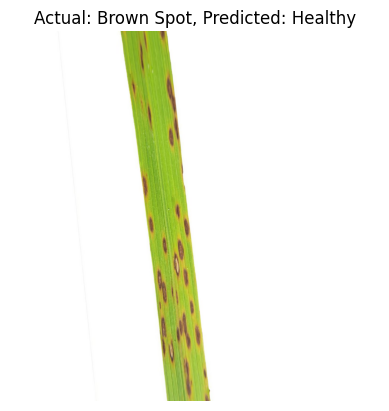

Actual Label: Brown Spot, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


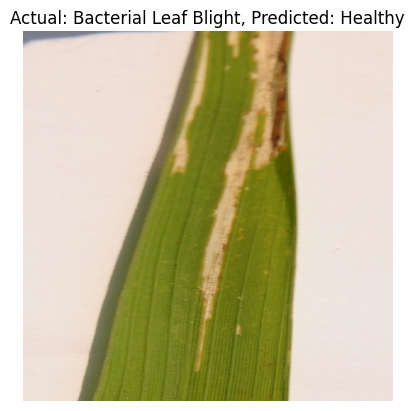

Actual Label: Bacterial Leaf Blight, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


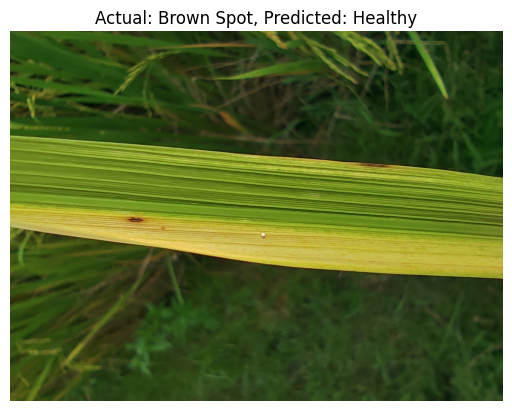

Actual Label: Brown Spot, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


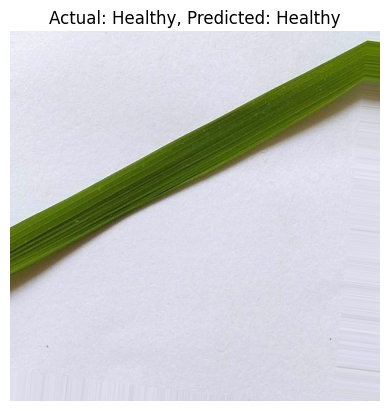

Actual Label: Healthy, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


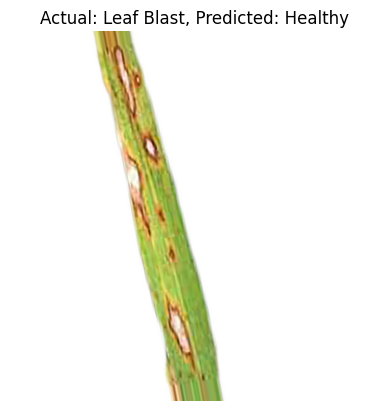

Actual Label: Leaf Blast, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


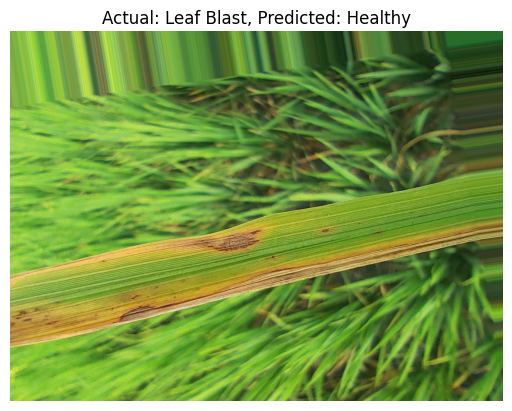

Actual Label: Leaf Blast, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


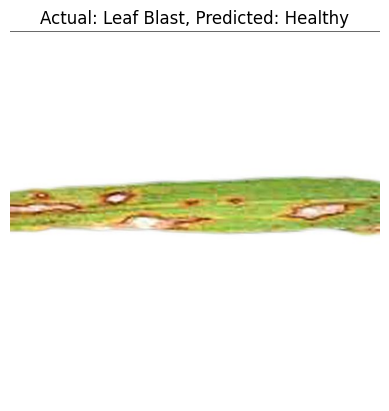

Actual Label: Leaf Blast, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


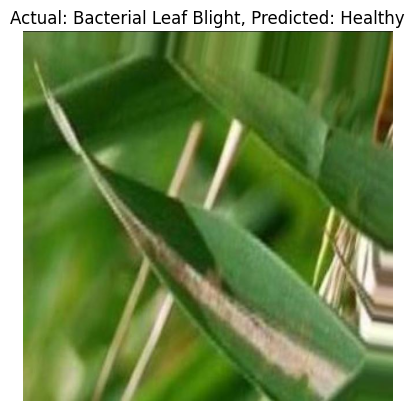

Actual Label: Bacterial Leaf Blight, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


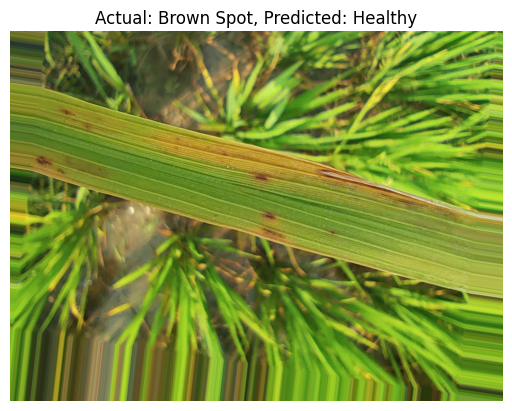

Actual Label: Brown Spot, Predicted Label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


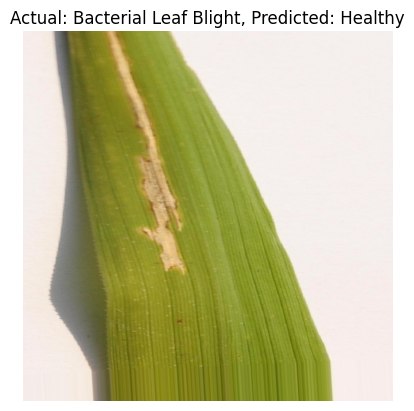

Actual Label: Bacterial Leaf Blight, Predicted Label: Healthy


In [60]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load a single image (no preprocessing)
def load_image_without_preprocessing(img_path, img_height, img_width):
    """Load an image without preprocessing for model prediction."""
    image = load_img(img_path, target_size=(img_height, img_width))
    image = img_to_array(image) / 255.0  # Normalize image
    return np.expand_dims(image, axis=0)  # Expand dimensions for model input

# Function to display image with actual and predicted labels
def display_image(img_path, actual_label, predicted_label):
    """Display the image with actual and predicted labels."""
    img = load_img(img_path)
    plt.imshow(img)
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# List of class names
class_names = list(class_indices.keys())

# Randomly select 10 images from the entire dataset
random_images = []
random_labels = []
for _ in range(10):
    category = random.choice(os.listdir(base_dir))  # Randomly choose a category
    category_path = os.path.join(base_dir, category)
    random_img_name = random.choice(os.listdir(category_path))  # Randomly choose an image
    random_img_path = os.path.join(category_path, random_img_name)
    
    random_images.append(random_img_path)
    random_labels.append(category)

# Predict the class of each randomly selected image
for img_path, actual_label in zip(random_images, random_labels):
    # Load the image (without any preprocessing)
    img = load_image_without_preprocessing(img_path, img_height, img_width)
    
    # Get model prediction
    prediction = model.predict(img)
    predicted_label = class_names[np.argmax(prediction)]
    
    # Display the image with actual and predicted labels
    display_image(img_path, actual_label, predicted_label)
    print(f'Actual Label: {actual_label}, Predicted Label: {predicted_label}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 800ms/step


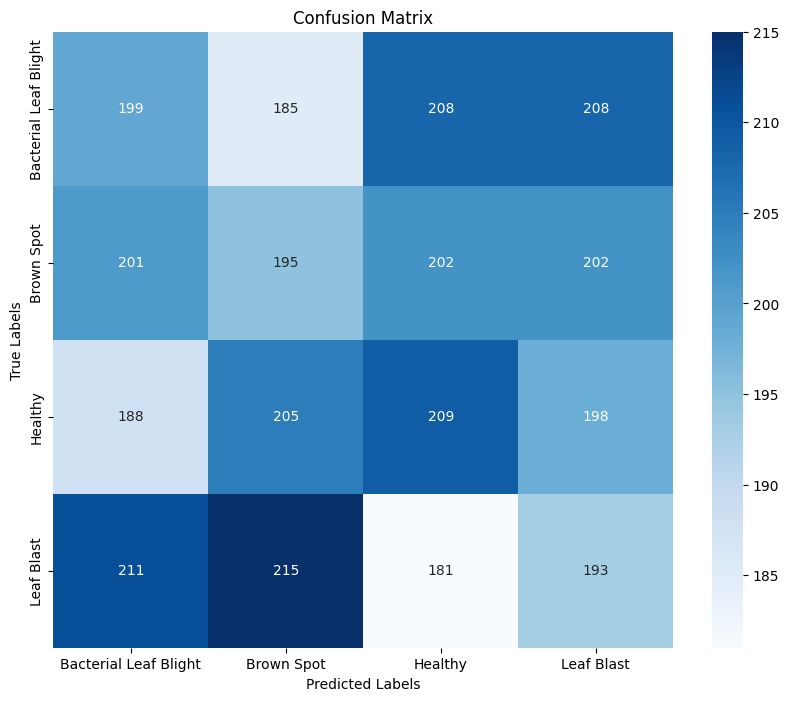

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.25      0.25      0.25       800
           Brown Spot       0.24      0.24      0.24       800
              Healthy       0.26      0.26      0.26       800
           Leaf Blast       0.24      0.24      0.24       800

             accuracy                           0.25      3200
            macro avg       0.25      0.25      0.25      3200
         weighted avg       0.25      0.25      0.25      3200



In [59]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the validation data
val_preds = model.predict(val_generator_original)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator_original.classes
class_labels = list(val_generator_original.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))

In [20]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

Found 12800 images belonging to 4 classes.
Epoch 1/20


I0000 00:00:1728557582.445068     101 service.cc:145] XLA service 0x7c9f24002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728557582.445125     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728557635.645302     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     50/Unknown 3019s 60s/step - accuracy: 0.4875 - loss: 1.6323

KeyboardInterrupt: 

In [26]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7265 - loss: 1.3844
Validation accuracy: 0.73


In [27]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step


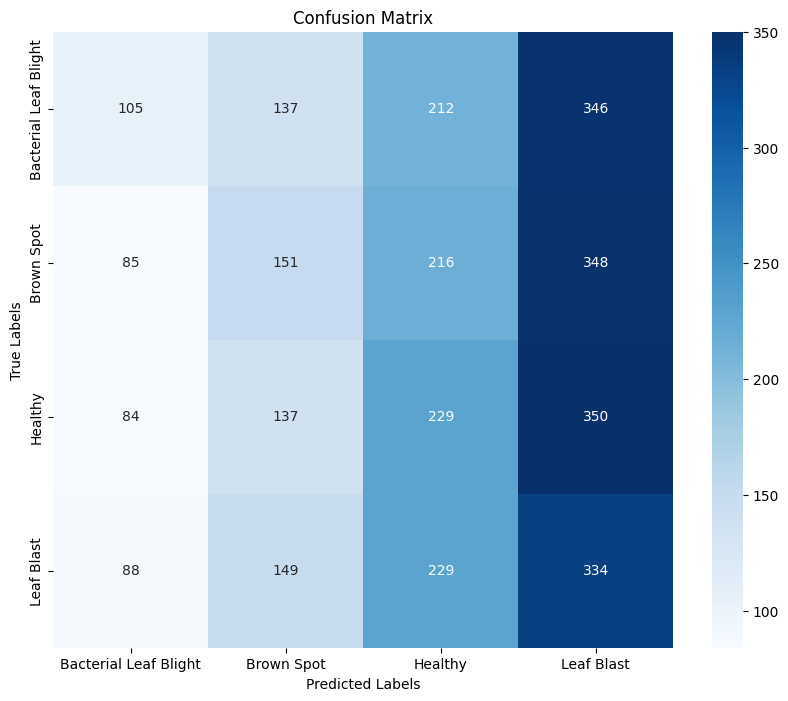

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.29      0.13      0.18       800
           Brown Spot       0.26      0.19      0.22       800
              Healthy       0.26      0.29      0.27       800
           Leaf Blast       0.24      0.42      0.31       800

             accuracy                           0.26      3200
            macro avg       0.26      0.26      0.24      3200
         weighted avg       0.26      0.26      0.24      3200



In [28]:
# Predict the validation data
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))